### Same as Untitled8 but using updated info table for growth rate column - seems to help.

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
%Rdevice svg
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
#%run -i read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [3]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info = sample_infos['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sizeme(info.head(3),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_US-1505885,Sample_US-1505885,Labcorp,US-1505885,PS 37 C log 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",sulfate respiration/growth,pyruvate 80mM,pyruvate,NaN,sulfate,0.13,37,D vulgaris Hildenborugh,NaN
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,0.11,37,D vulgaris Hildenborugh,NaN
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0.00,37,D vulgaris Hildenborugh,0


### Identify groups of replicates in the measurements -- using groupby

In [5]:
#info_tmp = info[info.columns[np.hstack([4,np.arange(6,14)])]]  ##.duplicated()
group_cols = info.columns[np.hstack([4,6,7,8,9,11,12,13,14])].values.astype(str).tolist()
#grouped = info.groupby(info.columns[np.hstack([4,np.arange(6,14)])].values)
#group_cols = ['cultivation type', 'Description/condition details',
#             'Description/condition details -2', 'carbon source', 'electron donor',
#             'concentration (mM)', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
print group_cols
grouped = info.groupby(group_cols, axis=0)
print len(grouped.groups), info.shape, info[group_cols].drop_duplicates().shape
#print grouped.groups[grouped.groups.keys()[0]]
print [len(i) for i in grouped.groups.values()]
col_groups = grouped.groups.values()
for i in grouped.groups.values():
    print i
    #print info.ix[i]['Description/condition details'].values
col_groups = grouped.groups.values()

['cultivation type', 'Description/condition details', 'Description/condition details -2', 'carbon source', 'electron donor', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
23 (57, 16) (23, 9)
[3, 3, 3, 3, 3, 5, 3, 1, 2, 3, 3, 2, 3, 2, 1, 2, 2, 1, 2, 3, 1, 4, 2]
['Sample_US-1510865', 'Sample_US-1510891', 'Sample_US-1510901']
['Sample_US-1505895', 'Sample_US-1505949', 'Sample_US-1510877']
['Sample_US-1510871', 'Sample_US-1510882', 'Sample_US-1510888']
['Sample_US-1510876', 'Sample_US-1510894', 'Sample_US-1510897']
['Sample_US-1505897', 'Sample_US-1505963', 'Sample_US-1510881']
['Sample_US-1510845', 'Sample_US-1510852', 'Sample_US-1510859', 'Sample_US-1510864', 'Sample_US-1510895']
['Sample_US-1505946', 'Sample_US-1505967', 'Sample_US-1505985']
['Sample_US-1510827']
['Sample_US-1510854', 'Sample_US-1510870']
['Sample_US-1505885', 'Sample_US-1506000', 'Sample_US-1510880']
['Sample_US-1505888', 'Sample_US-1505998', 'Sample_US-1510873']
['Sample_US-1510874', 'Sample_US-1510892

## OK, idea: remove all replicates of a given measurement, run Boruta to get big, best subset of variables that classify, then random forest (lots of trees) using those variables to get classifier. Test (predict) the random forest on the left-out measurements.

### Now do it for all test cases! -- i.e., all replicate sets

In [6]:
x = all_freqs['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
print x.shape
cols = grouped.groups.values()[0]
xx = np.log10(x+1e-1).fillna( 0 )

(3648, 57)


In [20]:
%Rpush x
%Rpush info
%R colnames(x) <- gsub('X..','',gsub('...1.','',colnames(x),fixed=T),fixed=T)
genes = x.index.values.astype('str')
print(genes)
%Rpush genes
%R good_gene = which(!substr(genes,1,2)=='__' & apply(x,1,sum)>0)
%R x = x[good_gene,]
%R rownames(x)=genes[good_gene]
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))
#%R save(col_groups,file='qqq')

['DVU0001' 'DVU0002' 'DVU0003' ..., '__too_low_aQual' '__not_aligned'
 '__alignment_not_unique']


[1] 23


In [21]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))

[1] 23


In [13]:
%%R -n
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

getY <- function(cond_type, info) {
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    names(Y) <- info$Sample.name
    cat(cond_type, length(levels(Y)), '\n')   
    return(Y)
}

do_it <- function(cond_type, x, cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
#     if (cond_type == 'growth_rate') {
#         gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
#         Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
#     } else if (cond_type == 'electron_donor') {
#         Y <- as.factor(as.character(info$electron.donor))
#     } else if (cond_type == 'electron_acceptor') {
#         Y <- as.factor(as.character(info$electron.acceptor))
#     } else if (cond_type == 'temperature') {
#         Y <- as.factor(as.character(info$T0C == 37))
#     } else if (cond_type == 'all') {
#         Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
#         Y2 <- as.character(info$electron.donor)
#         Y3 <- as.character(info$electron.acceptor)
#         Y4 <- as.character(info$T0C == 37)
#         Y <- as.factor(paste(Y1, Y2, Y3, Y4))
#     }
#     #cat(cond_type, length(levels(Y)), '\n')
#     names(Y) <- info$Sample.name
    Y <- getY(cond_type, info)

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    features <- character()
    B.temp1a <- try(Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0))
    if (class(B.temp1a) != 'try-error') features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    if (class(B.temp1a) == 'try-error' || length(features) < 2) {
        B.temp1a <- try(Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees*2, doTrace=0))
        if (class(B.temp1a) != 'try-error') features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    }
        
    if (length(features) < 2) features <- rownames(XX)        
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude], features=features)
    
    return(tmp)
}
NULL

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


NULL


In [22]:
%%R 
results = list()
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
    tmp <- mclapply( col_groups, function(cols) {
        cols = unlist(cols)
        tmp <- do_it(cond_type, x.ranks, cols)
        #cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        return(tmp)
    }, mc.preschedule=F )
    cat(cond_type, mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))), '\n')
    results[[cond_type]] <- tmp
}

electron_donor 0.9824561 
electron_acceptor 0.8070175 
temperature 0.8421053 
growth_rate 0.7368421 


In [23]:
%R print(sapply(results,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
%R print(sapply(results,function(tmp)length(levels(unlist(lapply(tmp,'[[','actual'))))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results

   electron_donor electron_acceptor       temperature       growth_rate 
        0.9824561         0.8070175         0.8421053         0.7368421 


   electron_donor electron_acceptor       temperature       growth_rate 
                3                 3                 2                 2 


### See which classes are most misclassified (growth_rate).
#### looks like fast growth is most often misclassified as no growth (and vice versa).

In [ ]:
%%R -n
tmp1=unlist(lapply(lapply(results$growth_rate,'[[','predicted'),as.character))
tmp2=unlist(lapply(lapply(results$growth_rate,'[[','actual'),as.character))
print(table(tmp2[tmp1!=tmp2]))   ## which actual classes are most frequently misclassified
print(table(tmp1[tmp1!=tmp2]))   ## which predicted classes are they most frequently misclassified as
cbind(predicted=tmp1[tmp1!=tmp2],actual=tmp2[tmp1!=tmp2])   ## misclassification pairs (predicted, actual)

### For comparison, do it for the full data sets in which we did not leave any conditions out

In [24]:
%%R
    results_noleaveout = list()
    for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
#         if (cond_type == 'growth_rate') {
#             gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
#             Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
#         } else if (cond_type == 'electron_donor') {
#             Y <- as.factor(as.character(info$electron.donor))
#         } else if (cond_type == 'electron_acceptor') {
#             Y <- as.factor(as.character(info$electron.acceptor))
#         } else if (cond_type == 'temperature') {
#             Y <- as.factor(as.character(info$T0C == 37))
#         } else if (cond_type == 'all') {
#             Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
#             Y2 <- as.character(info$electron.donor)
#             Y3 <- as.character(info$electron.acceptor)
#             Y4 <- as.character(info$T0C == 37)
#             Y <- as.factor(paste(Y1, Y2, Y3, Y4))
#         }
        Y <- getY(cond_type, info)
        cat(cond_type, length(levels(Y)), '\n')

        B.temp1a <- Boruta(t(x.ranks), Y, getImp=getImpFerns, ferns=100000, doTrace=0)
        features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
        rf.temp1a <- randomForest(t(x.ranks[features,]), Y, importance=T, ntree=100000, do.trace=F)
        tmp = list(predicted=predict(rf.temp1a), actual=Y, features=features)

        ##print(lapply(tmp,function(i)mean(i$predicted==i$actual)))
        cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        results_noleaveout[[cond_type]] <- tmp
    }

electron_donor 3 
electron_donor 3 
electron_donor 1 
electron_acceptor 3 
electron_acceptor 3 
electron_acceptor 0.9298246 
temperature 2 
temperature 2 
temperature 0.9649123 
growth_rate 2 
growth_rate 2 
growth_rate 0.8947368 


In [25]:
%R print(apply(sapply(results_noleaveout,'[[','predicted') == sapply(results_noleaveout,'[[','actual'),2,mean))
%R print(sapply(results_noleaveout,function(tmp)length(levels(tmp$actual))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results_noleaveout
%R rm(rf.temp1a,B.temp1a); save.image("Untitled9.RData")

   electron_donor electron_acceptor       temperature       growth_rate 
        1.0000000         0.9298246         0.9649123         0.8947368 


   electron_donor electron_acceptor       temperature       growth_rate 
                3                 3                 2                 2 


### Let's try the removing of the lowest-expressed genes incrementally and see how training/testing works for electron_donor conditions:

##### lets do it by quantiles first, just to see (try 8 quantiles???):

In [27]:
%%R
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
#cond_type <- 'electron_donor'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
tmp_lst <- lapply( 1:length(col_groups), function(col) {
    #cols = unlist(col_groups[[13]])
    cols <- col_groups[[col]]
    cols <- unlist(cols)
    cols2 <- gsub('-','.',cols)   ## try a pyruvate condition  -- all predicted correctly
    mns <- apply(x.ranks[,cols2, drop=F], 1, median)
    levels <- quantile(mns, inp_quantiles)
    tmp <- mclapply( rev(levels), function(lev) {
        cat(col, 'of', length(col_groups), rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), cond_type, '\n')
        xx <- x.ranks[mns > lev,, drop=F]
        ttmp <- do_it(cond_type, xx, cols)
        #cat(lev, sum(mns>lev), cond_type, mean(as.character(ttmp$predicted) == as.character(ttmp$actual)), '\n')
        return(ttmp)
    }, mc.preschedule=F )
    #print(apply(sapply(tmp,'[[','predicted') == sapply(tmp,'[[','actual'),2,mean))
    return( tmp )
} )
#print(sapply(tmp_lst,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
qqq[[cond_type]] <- tmp_lst
}

NULL


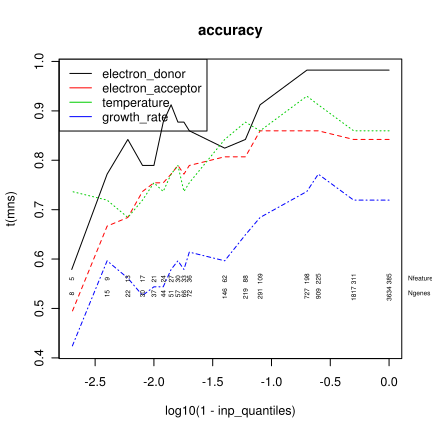

In [28]:
%%R
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)tmp2[[lev]]$predicted==unlist(tmp2[[lev]]$actual))))))
colnames(mns)<-names(qqq$growth_rate[[1]])
mns<-mns[,ncol(mns):1]
expr_levels = quantile(apply(x.ranks,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x.ranks,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)length(tmp2[[lev]]$features))))))
colnames(n_features)<-names(qqq$growth_rate[[1]])
n_features<-n_features[,ncol(n_features):1]

matplot(log10(1-inp_quantiles),t(mns),typ='l',main='accuracy')
legend('topleft',legend=rownames(mns),lwd=1,col=1:4)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.53, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.53, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.56, lab=as.character(round(apply(n_features,2,mean))),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.56, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)

NULL

In [35]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
//var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [37]:
#%R save.image('qqq')
%Rpush NOTEBOOK_FULL_PATH
%R save.image(paste(gsub('ipynb','RData',NOTEBOOK_FULL_PATH)))

### Get list of (importance-ranked) genes for each condition... we are going to use Boruta but limit the genes to only those that showed up at least once in the classifications above...

### First -- electron donor!!!

electron_donor 3 


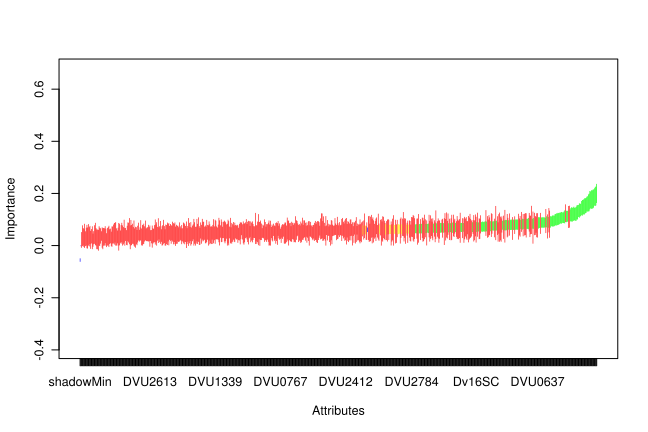

In [42]:
%%R -w 9
imp_genes_list <- list()
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$electron_donor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('electron_donor', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$electron_donor <- imp_genes

In [43]:
%Rpull imp_genes
print ' '.join(imp_genes)
#query = '%22'+'%22+%22'.join(imp_genes)+'%22'
#query = 'http://networks.systemsbiology.net/search?q='+query
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

DVU2292 DVU3029 DVU3030 DVU2291 DVU3032 DVU3033 DVU3027 DVU3031 DVU3025 DVU3028 DVU2287 DVU3024 DVU2290 DVU3026 DVU2650 DVU2289 DVU2288 DVU2293 DVU2451 DVU2286 DVU2092 DVU0031 DVU2093 DVU2452 DVU0032 DVU0434 DVU0550 DVU0432 DVU0430 DVU2211 DVU2094 DVU0431 DVU2095 DVU0429 DVU0433 DVU3276 DVU2667 DVU2203 DVU0649 DVU0549 DVU1295 DVU0819 DVU2666 DVU3282 DVU2091 DVU2752 DVU3187 DVU0614 DVU0750 DVU0650 DVU0446 DVU0223 DVU1418 DVU4027 DVU2783 DVU2652 DVU0415 DVU3104 DVU2969 DVU2751 DVU2753 DVU2116 DVU0360 DVU0847 DVU0036 DVU1203 DVU3047 DVU2792 DVU0547 DVU2381 DVU0148 DVU0551 DVU3008 DVU0845 DVU1932 DVU0524 DVU1636 DVU0392 DVU0851 DVU0146 DVU1444 DVU1545 DVU2444 DVU2383 DVU0145 DVU0647 DVU1032 DVU2388 DVU0259 DVU0567 DVU0850 DVU0712 DVU1669 DVU0534 DVU4015 DVU3348 DVU0425 DVU2108 DVU0295 DVU0055 DVU2377 DVU2105 DVU2201 DVU2106 DVU1990 DVU2448 DVU1796 DVU0072 DVU0512 DVU1397 DVU2747 DVU1381 DVU2793 DVU0693 DVU1238 DVU0147 DVU0648 DVU0273 DVU0041 DvtmRNA1 DVU0519 DVU2994 DVU0299 DVU2778 DVU2380

### Second -- electron acceptor!!!

electron_acceptor 3 


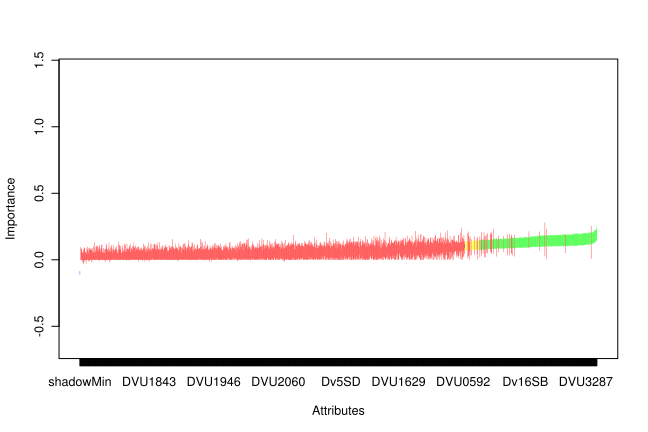

In [51]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$electron_acceptor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('electron_acceptor', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$electron_acceptor <- imp_genes

In [52]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

DVU2105 DVU2135 DVU0524 DVU2108 DVU1962 DVU0523 DVU2104 DVU2107 DVU0530 DVU0700 DVU1339 DVU2299 DVU2444 DVU2298 DVU0512 DVU2290 DvtmRNA1 DVU2291 DVU2103 DVU0316 DVU2543 DVU0534 DVU0041 DVU3287 DVU0532 DVU2109 DVU0533 DVU1444 DVU0313 DVUA0116 DVU2292 DVU2289 DVU0170 DVUA0018 DVUA0028 DVUA0017 DVUA0134 DVUA0006 DVUA0123 DVUA0130 DVU0056 DVUA0136 DVUA0121 DVUA0021 DVUA0003 DVU3032 DVUA0118 DVUA202 DVUA0113 DVU3025 DVUA0114 DVUA0125 DVU3282 DVUA0004 DVUA0023 DVUA0131 DVU1338 DVUA0147 DVU0614 DVUA0117 DVU0317 DVUA0073 DVUA0005 DVU0531 DVU3033 DVUA0081 DVUA0100 DVUA0020 DVUA0145 DVU2679 DVUA0115 DVUA0112 DVU3030 DVU3027 DVU0594 DVU1407 DVUA0135 DVUA0019 DVU3024 DVUA0074 DVUA0104 DVUA0071 DVUA0120 DVUA0080 DVUA0079 DVUA204 DVU2297 DVU2991 DVUA0078 DVU3029 DVUA0085 DVU2211 DVUA203 DVUA0077 DVUA0111 DVUA0148 DVUA0002 DVUA0070 DVUA0084 DVU2544 DVUA0105 DVUA0110 DVUA201 DVUA0086 DVUA0150 DVU2288 DVU3018 DVUA0037 DVUA0108 DVUA0109 DVUA0106 DVUA0097 DVUA0072 DVUA0098 DVU1363 DVU1923 DVUA0087 DVUA00

### Third -- temperature!!!

temperature 2 


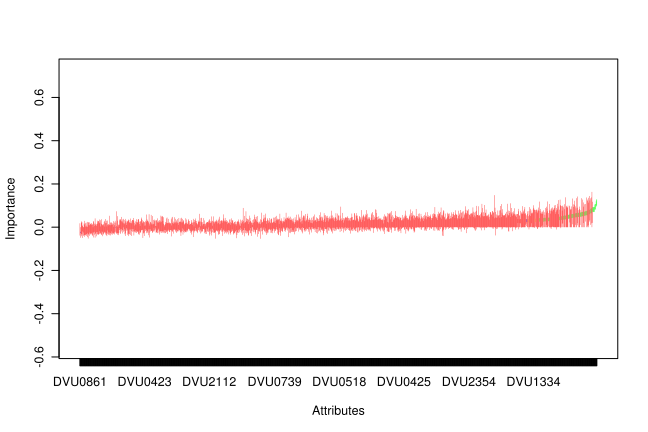

In [46]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$electron_acceptor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('temperature', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$temperature <- imp_genes

In [47]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

DVU3299 DVU1337 DVU3134 DVU0260 DVU3272 DVU3132 DVU0966 DVU2554 DVU0322 DVU0261 DVU0936 DvtmRNA1 DVU0092 DVU1777 DVU2555 DVU_tRNA.Leu.3 DVU2927 DVU3006 DVU0264 DVU1617 DVU0088 DVU0310 DVU3090 DVU0295 DVU0677 DVU0312 DVU3013 DVU2590 DVU2926 DVU1902 DVU0732 DVU0041 DVU0876 DVU2719 DVU3211 DVU0845 DVU2552 DVU2924 DVU0927 DVU0968 DVU2921 DVU1298 DVU1936 DVU1745 DVU0959
http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery=DVU3299+OR+DVU1337+OR+DVU3134+OR+DVU0260+OR+DVU3272+OR+DVU3132+OR+DVU0966+OR+DVU2554+OR+DVU0322+OR+DVU0261+OR+DVU0936+OR+DvtmRNA1+OR+DVU0092+OR+DVU1777+OR+DVU2555+OR+DVU_tRNA.Leu.3+OR+DVU2927+OR+DVU3006+OR+DVU0264+OR+DVU1617+OR+DVU0088+OR+DVU0310+OR+DVU3090+OR+DVU0295+OR+DVU0677+OR+DVU0312+OR+DVU3013+OR+DVU2590+OR+DVU2926+OR+DVU1902+OR+DVU0732+OR+DVU0041+OR+DVU0876+OR+DVU2719+OR+DVU3211+OR+DVU0845+OR+DVU2552+OR+DVU2924+OR+DVU0927+OR+DVU0968+OR+DVU2921+OR+DVU1298+OR+DVU1936+OR+DVU1745+OR+DVU0959


### Fourth -- growth rate!!!

growth_rate 2 


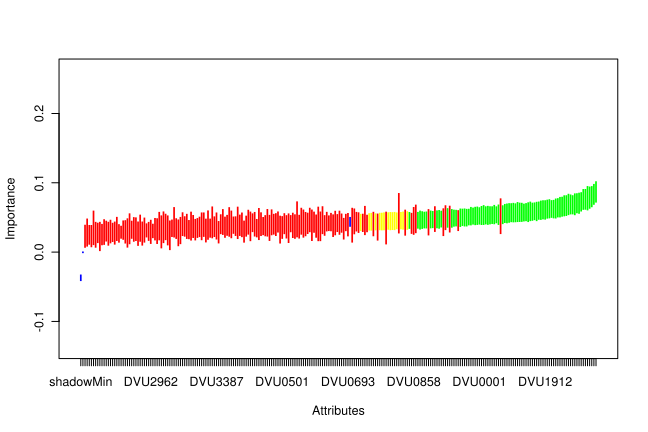

In [48]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$growth_rate,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('growth_rate', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$growth_rate <- imp_genes

In [49]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

DVU4007 DVU1629 DVU2928 DVU1468 DVU2135 DVU1791 DVU2472 DVU1241 DVU0566 DVU1286 DVU2548 DVU0423 DVU0082 DVU2325 DVU2105 DVU1790 DVU3217 DVU1339 DVU3084 DVU3234 DVU2324 DVU0598 DVU1911 DVU3151 DVU0486 DVU1912 DVU1290 DVU0595 DVU0810 DVU1824 DVU3088 DVU1287 DVU0808 DVU1421 DVU1419 DVU1289 DVU1573 DVU0056 DVU2212 DVU2929 DVU0302 DVU1203 DVU1338 DVU0383 DVU3346 DVU0524 DVU0512 DVU1248 DVU1805 DVU1949 DVU2108 DVU0241 DVU1962 DVU0995 DVU3287 DVU0001 DVU2993 DVU1834 DVU2446 DVU2635 DVU1070 DVU1602 DVU0707 DVU1343 DVU1950 DVU3180 DVU0316 DVU2444 DVU2974 DVU0938 DVU3222 DVU1303 DVU0165 DVU2749 DVU0756 DVU2419 DVU0692 DVU2335 DVU2107
http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery=DVU4007+OR+DVU1629+OR+DVU2928+OR+DVU1468+OR+DVU2135+OR+DVU1791+OR+DVU2472+OR+DVU1241+OR+DVU0566+OR+DVU1286+OR+DVU2548+OR+DVU0423+OR+DVU0082+OR+DVU2325+OR+DVU2105+OR+DVU1790+OR+DVU3217+OR+DVU1339+OR+DVU3084+OR+DVU3234+OR+DVU2324+OR+DVU0598+OR+DVU1911+OR+DVU3151+OR+DVU0486+OR+DVU191

In [50]:
%R save.image(paste(gsub('ipynb','RData',NOTEBOOK_FULL_PATH)))